In [ ]:
!nvidia-smi

Wed Nov  8 11:53:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
import cupy as cp
import numpy as np

In [ ]:
d_a = cp.linspace(0, 2**20, 2**20, dtype = cp.float32)
d_b = cp.linspace(0, 2**20, 2**20, dtype = cp.float32)

d_c = d_a + d_b
d_c = 2*d_c
d_c = 5*d_c + d_b

h_c = d_c.get()

In [ ]:
print(d_c[5])   # BEWARE

105.0001


In [ ]:
%%timeit

d_a = cp.random.rand(10,10)
d_a = d_a.astype(cp.float32)

d_b = cp.random.rand(10,10)
d_b = d_b.astype(cp.float32)

d_c = d_a @ d_b

h_c = d_c.get()

194 µs ± 30.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%%timeit

h_a = np.random.rand(10,10)
h_a = h_a.astype(np.float32)

h_b = np.random.rand(10,10)
h_b = h_b.astype(np.float32)

h_c = h_a @ h_b

#h_c = d_c.get()

9.37 µs ± 2.57 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [ ]:
print(h_c)

[0.000000e+00 2.000002e+00 4.000004e+00 ... 2.097148e+06 2.097150e+06
 2.097152e+06]


In [ ]:
%%timeit
h_a = np.linspace(0, 2**20, 2**20, dtype = np.float32)
h_b = np.linspace(0, 2**20, 2**20, dtype = np.float32)

h_c = h_a + h_b

6.57 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
6.84 / 0.232

29.482758620689655

In [ ]:
%%timeit
d_a = cp.random.randn(1024, 1024, dtype = cp.float32)
d_b = cp.random.randn(1024, 1024, dtype = cp.float32)

d_c = d_a @ d_b

733 µs ± 9.94 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%%timeit
h_a = np.random.randn(1024, 1024, dtype = np.float32)
h_b = np.random.randn(1024, 1024, dtype = np.float32)

h_c = h_a @ h_b

In [ ]:
%%timeit
h_a = np.random.rand(1000,1000)
h_a = h_a.astype(np.float32)

h_b = np.random.rand(1000,1000)
h_b = h_b.astype(np.float32)

h_c = h_a @ h_b



45.3 ms ± 914 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%writefile hello.cu

#include <stdio.h>
#include <iostream>

__global__ void helloKernel() {
    int tid = threadIdx.x;
    printf("I am thread #%d\n", tid);
}

__global__ void Init(float* d_a) {
    int tid = threadIdx.x + blockIdx.x * blockDim.x;
    d_a[tid] = tid;
}

__global__ void Square(float* d_a) {
    int tid = threadIdx.x + blockIdx.x * blockDim.x;
    d_a[tid] = d_a[tid] * d_a[tid];
}

int main() {

    float* d_a;
    cudaMallocManaged(&d_a, 64 * sizeof(float));

    Init<<<2, 32>>>(d_a);
    Square<<<2, 32>>>(d_a);
    cudaDeviceSynchronize();

    for(auto i = 0; i<32; ++i)
        std::cout << d_a[i] << std::endl;

    cudaFree(d_a);
    return 0;
}

Overwriting hello.cu


In [ ]:
!nvcc hello.cu -o test

In [ ]:
!./test

0
1
4
9
16
25
36
49
64
81
100
121
144
169
196
225
256
289
324
361
400
441
484
529
576
625
676
729
784
841
900
961


In [ ]:
square = cp.ElementwiseKernel(
   'float32 x',
   'float32 y',
   'y = x * x + 5',
   'square')

In [ ]:
d_x = cp.linspace(0, 32, 32, dtype=cp.float32, endpoint=False)

d_y = square(d_x)


In [ ]:
print(d_y)

[  5.   6.   9.  14.  21.  30.  41.  54.  69.  86. 105. 126. 149. 174.
 201. 230. 261. 294. 329. 366. 405. 446. 489. 534. 581. 630. 681. 734.
 789. 846. 905. 966.]


In [ ]:
#generic kernel
square = cp.ElementwiseKernel(
   'T x',
   'T y',
   'y = x * x + 5',
   'square')

In [ ]:
d_x = cp.linspace(0, 32, 32, dtype=cp.int32, endpoint=False)
d_y = square(d_x)

In [ ]:
d_y

array([  5,   6,   9,  14,  21,  30,  41,  54,  69,  86, 105, 126, 149,
       174, 201, 230, 261, 294, 329, 366, 405, 446, 489, 534, 581, 630,
       681, 734, 789, 846, 905, 966], dtype=int32)

In [ ]:
# https://docs.cupy.dev/en/stable/user_guide/kernel.html

In [ ]:
add_kernel = cp.RawKernel(r'''
extern "C" __global__
void my_add(const float* x1, const float* x2, float* y) {
    int tid = blockDim.x * blockIdx.x + threadIdx.x;
    y[tid] = x1[tid] + x2[tid];
}
''', 'my_add')

In [ ]:
d_x = cp.linspace(0, 64, 64, dtype=cp.float32, endpoint=False)
d_y = cp.linspace(0, 64, 64, dtype=cp.float32, endpoint=False)
d_z = cp.empty_like(d_x)

add_kernel((1,1,2), (16,2,1), (d_x, d_y, d_z)) #first arg - blocks; second arg - threads

In [ ]:
d_z

array([ 0.      ,  2.      ,  4.      ,  6.      ,  8.      , 10.      ,
       12.      , 14.      , 16.      , 18.      , 20.      , 22.      ,
       24.      , 26.      , 28.      , 30.      ,  0.      ,  2.5     ,
        0.      ,  2.53125 ,  0.      ,  2.5625  ,  0.      ,  2.59375 ,
        0.      ,  2.625   ,  0.      ,  2.65625 ,  0.      ,  2.6875  ,
        0.      ,  2.71875 ,  0.      ,  2.75    ,  0.      ,  2.765625,
        0.      ,  2.78125 ,  0.      ,  2.796875,  0.      ,  2.8125  ,
        0.      ,  2.828125,  0.      ,  2.84375 ,  0.      ,  2.859375,
        0.      ,  2.875   ,  0.      ,  2.890625,  0.      ,  2.90625 ,
        0.      ,  2.921875,  0.      ,  2.9375  ,  0.      ,  2.953125,
        0.      ,  2.96875 ,  0.      ,  2.984375], dtype=float32)

In [ ]:
# on your own laptop
# 1. install cuda
# 2. pip install cupy-cuda116  (?)
# or conda install ...


In [ ]:
#d_a = cp.ones(128, dtype = cp.uint8)
d_a = cp.linspace(0,1, 128, dtype = cp.float32)
d_a = cp.random.rand(128).astype(cp.float32)
d_b = cp.zeros(128, dtype = cp.float32)

In [ ]:
from cupyx import jit

@jit.rawkernel()
def my_kernel(d_a, d_b, size):
    global_block_index = jit.blockIdx.x + \
                         jit.blockIdx.y * jit.gridDim.x + \
                         jit.blockIdx.z * jit.gridDim.x * jit.gridDim.y

    tid_in_block = jit.threadIdx.x + \
                   jit.threadIdx.y * jit.blockDim.x + \
                   jit.threadIdx.z * jit.blockDim.x * jit.blockDim.y

    gid = tid_in_block + global_block_index * \
                         jit.blockDim.x * jit.blockDim.y * jit.blockDim.z

    if gid > 0 and gid < size-1:
        d_b[gid] = 1/3 * (d_a[gid-1] + d_a[gid] + d_a[gid+1])
    elif gid == 0:
        d_b[gid] = 0.5 * (d_a[gid] + d_a[gid+1])
    else:
        d_b[gid] = 0.5 * (d_a[gid] + d_a[gid-1])




In [ ]:
my_kernel((1,1,1), (128,1,1), (d_a, d_b, 128))

In [ ]:
import matplotlib.pyplot as plt

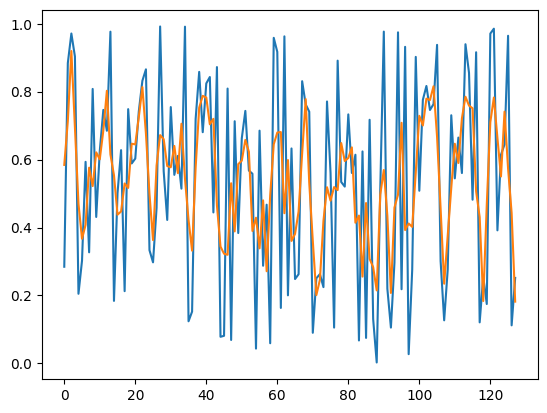

In [ ]:
plt.plot(d_a.get())
plt.plot(d_b.get())